In [171]:
import torch
from net import Net  # Importez la classe Net depuis votre fichier net.py
import torchvision.transforms as transforms
from PIL import Image

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [196]:
# Charger votre modèle pré-entraîné
model = Net()
model.load_state_dict(torch.load('model_new_archi.pth'))
model.eval()

# Définir vos transformations pour les régions de la fenêtre
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,)),
])

# Charger votre image (à remplacer par l'image sur laquelle vous voulez effectuer la détection)
image = Image.open('images_sliding_window/image_visages_2.jpg')

# Spécifier la taille de la fenêtre et le chevauchement 
window_size = 36
overlap = 0.5

# Convertir l'image en tenseur
image_tensor = transform(image)

# Obtenir les dimensions de l'image
img_width, img_height = image.size

print ("Image size: ", image.size)
print ("Window size: ", window_size)
print ("Overlap: ", overlap)

Image size:  (737, 423)
Window size:  36
Overlap:  0.5


C:\Users\Nathan\AppData\Local\Temp\ipykernel_9972\4256142036.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = torch.nn.functional.softmax(output)


Nombre de visages détectés : 55


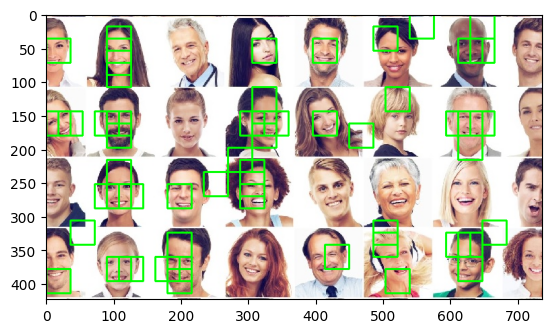

In [197]:
# Liste pour stocker les caractéristiques des fenêtres détectant des visages
detected_faces = []

# Nombre de visages détectés
nb_visages = 0

# Parcourir l'image avec la fenêtre coulissante
for y in range(0, img_height - window_size, int(window_size * (1 - overlap))):
    for x in range(0, img_width - window_size, int(window_size * (1 - overlap))):
        # Extraire la région de la fenêtre
        window = image_tensor[:, y:y+window_size, x:x+window_size].unsqueeze(0)  # Ajouter une dimension de lot

        # Faire la prédiction avec le modèle
        with torch.no_grad():
            output = model(window)
            # softmax pour obtenir les probabilités
            output = torch.nn.functional.softmax(output)
            _, predicted = torch.max(output.data, 1)

        # Si un visage est détecté, enregistrez ses caractéristiques
        if output[0,1] > 0.1:
            detected_faces.append((x, y))
            nb_visages += 1
        
# Afficher l'image avec les fenêtres détectant des visages
image_1 = np.array(image)
for x, y in detected_faces:
    cv2.rectangle(image_1, (x, y), (x+window_size, y+window_size), (0, 255, 0), 2)
plt.imshow(image_1)
        

# Nombre de visages détectés
print(f"Nombre de visages détectés : {len(detected_faces)}")

(-0.5, 736.5, 422.5, -0.5)

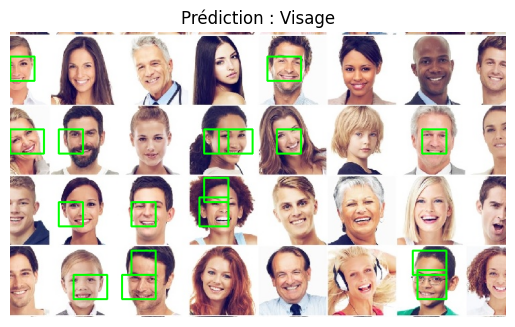

In [178]:
# Structure pour sauvegarder les coordonnées des visages détectés
faces = []

# Parcourir les emplacements des visages détectés pour agrandir les visages
for x, y in detected_faces:
    # Créez une fenêtre autour de l'emplacement du visage détecté
    new_x = x
    new_y = y
    new_window_size = window_size

    min_x, min_y, max_x, max_y = new_x, new_y, new_x + new_window_size, new_y + new_window_size

    # Parcourez les positions adjacentes avec un chevauchement de 80%
    for dx in [-int(0.2 * window_size), int(0.2 * window_size)]:
        for dy in [-int(0.2 * window_size), int(0.2 * window_size)]:
            if (dx + new_x) >= 0 and (dy+new_y) >= 0:
                new_x += dx
                new_y += dy

                # Extraire la région de la nouvelle fenêtre
                new_window = image_tensor[:, new_y:new_y+window_size, new_x:new_x+window_size].unsqueeze(0)

                # Faire la prédiction avec le modèle
                with torch.no_grad():
                    output = model(new_window)
                    _, predicted = torch.max(output.data, 1)

                # Si le résultat est "visage", affichez l'image agrandie du visage
                if predicted.item() == 1:
                    min_x = min(min_x, new_x)
                    min_y = min(min_y, new_y)
                    max_x = max(max_x, new_x + window_size)
                    max_y = max(max_y, new_y + window_size)

    faces.append((min_x, min_y, max_x, max_y))
    

# Draw the rectangles around the detected faces
image_2 = np.array(image)
for x, y, x2, y2 in faces:
    cv2.rectangle(image_2, (x, y), (x2, y2), (0, 255, 0), 2)

# Show the image with the detected faces
plt.title(f"Prédiction : Visage")
plt.imshow(image_2)
plt.axis('off')


Try iteratif

In [169]:
# Fonction qui détermine si des rectangles se chevauchent
# Si intersection, fusionner les deux rectangles
# Entrée : liste de faces détectées
# Sortie : liste de faces fusionnées
def fusionner_rectangles(faces):
    # Liste pour stocker les rectangles fusionnés
    faces_fusionnees = []

    # Parcourir les rectangles
    for x, y, x2, y2 in faces:
        # Si la liste est vide, ajoutez le rectangle
        if len(faces_fusionnees) == 0:
            faces_fusionnees.append((x, y, x2, y2))
        else:
            # Parcourir les rectangles fusionnés
            for i, (fx, fy, fx2, fy2) in enumerate(faces_fusionnees):
                # Si les rectangles se chevauchent, fusionnez-les
                if (x >= fx and x <= fx2) or (x2 >= fx and x2 <= fx2):
                    # Mettre à jour les coordonnées du rectangle fusionné
                    faces_fusionnees[i] = (min(x, fx), min(y, fy), max(x2, fx2), max(y2, fy2))
                    break
                else:
                    # Si le rectangle ne se chevauche pas avec les rectangles fusionnés, ajoutez-le
                    if i == len(faces_fusionnees) - 1:
                        faces_fusionnees.append((x, y, x2, y2))

    return faces_fusionnees


(-0.5, 736.5, 422.5, -0.5)

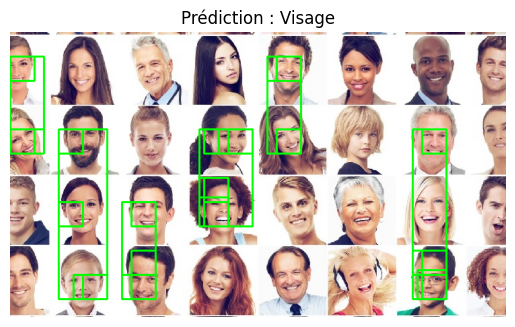

In [170]:
new_faces = fusionner_rectangles(faces)
# Draw the rectangles around the detected faces
image = np.array(image)
for x, y, x2, y2 in new_faces:
    cv2.rectangle(image, (x, y), (x2, y2), (0, 255, 0), 2)

# Show the image with the detected faces
plt.title(f"Prédiction : Visage")
plt.imshow(image)
plt.axis('off')